## **Load Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re 
import nltk 


from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


from sklearn.metrics import classification_report



In [3]:
# Import cleaned data

train=pd.read_csv("/content/drive/MyDrive/ProjectAI/Data/Cleaned/clean_train.csv")
test=pd.read_csv("/content/drive/MyDrive/ProjectAI/Data/Cleaned/clean_test.csv")

In [4]:
train

,labels,text
0,1,menyrbie phil_gahan chrisitv
1,2,advice talk neighbours family exchange phone n...
2,2,coronavirus australia woolworths give elderly ...
3,2,food stock one empty please dont panic enough ...
4,0,ready go supermarket covid outbreak im paranoi...
...,...,...
41152,1,airline pilots offering stock supermarket shel...
41153,0,response complaint provided citing covid relat...
41154,2,know itâs getting tough kameronwilds rationing...
41155,1,wrong smell hand sanitizer starting turn coron...


In [5]:
test

,labels,text
0,0,trending new yorkers encounter empty supermark...
1,2,couldnt find hand sanitizer fred meyer turned ...
2,2,find protect loved ones coronavirus
3,0,panic buying hits newyork city anxious shopper...
4,1,toiletpaper dunnypaper coronavirus coronavirus...
...,...,...
3793,2,meanwhile supermarket israel people dance sing...
3794,0,panic buy lot nonperishable items echo needs f...
3795,1,asst prof economics cconces nbcphiladelphia ta...
3796,0,gov need somethings instead biar je rakyat ass...


In [6]:
train.fillna('', inplace=True)
test.fillna('', inplace=True)

## **Extract Features**

In [7]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


In [8]:
from keras.models import Sequential

In [9]:
from keras.layers import Embedding , SpatialDropout1D, LSTM, Dense

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
import seaborn as sb
from matplotlib import pyplot as plt


In [14]:
type(train['text'])

pandas.core.series.Series

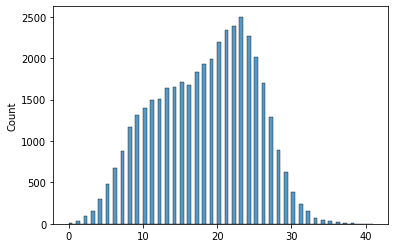

In [15]:
# Length of comments 

sent_length=[]
for i in range (len(train["text"])):
  sent_length.append(len(word_tokenize(train["text"][i])))
sb.histplot(sent_length,binwidth=0.5)
plt.show()

In [16]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 100000

# Max number of words in each comment 
MAX_SEQUENCE_LENGTH = 50

# Tokenizer
EMBEDDING_DIM = 64
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train["text"])


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 59215 unique tokens.


In [17]:
# Vectorize 
X = tokenizer.texts_to_sequences(train["text"])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (41157, 50)


In [18]:
Y = pd.get_dummies(train["labels"])
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (41157, 3)


In [19]:
X_train= X
Y_train = Y

In [20]:
X_test = tokenizer.texts_to_sequences(test["text"])
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
Y_test = pd.get_dummies(test["labels"])

##**ANN model**

In [34]:
from keras import layers

In [35]:
from tensorflow import keras

In [36]:
# ANN model
models = keras.models.Sequential([
      layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),

      layers.Dense(128),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(128),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      
      

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.GlobalMaxPool1D(),

      layers.Dense(3,activation='softmax')
  ])
models.summary()
# Choose loss function , optimizer function
models.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=4, #Stop the model training if the validation accuracy doesnt increase in 4 consecutive Epochs
                   restore_best_weights=True)
epochs = 10
batch_size = 128

history = models.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,callbacks =[es], validation_split=0.1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            6400000   
                                                                 
 dense (Dense)               (None, 50, 128)           8320      
                                                                 
 batch_normalization (BatchN  (None, 50, 128)          512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 50, 128)           0         
                                                                 
 dense_1 (Dense)             (None, 50, 128)           16512     
                                                                 
 batch_normalization_1 (Batc  (None, 50, 128)          512       
 hNormalization)                                        

In [37]:
# Accuracy of test set
score1 = models.evaluate(X_test,Y_test,verbose=0)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(score1[0],score1[1]))

Test set
  Loss: 0.6405
  Accuracy: 0.7873


In [38]:
# ANN model with Drop out 
model1 = keras.models.Sequential([
      layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),

      layers.Dense(128),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.Dense(128),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Dropout(0.2),
      
      
      

      layers.Dense(64),
      layers.BatchNormalization(),
      layers.Activation('relu'),

      layers.GlobalMaxPool1D(),

      layers.Dropout(0.2),
      layers.Dense(3,activation='softmax')
  ])
model1.summary()
# Choose loss function , optimizer function
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=4, #Stop the model training if the validation accuracy doesnt increase in 4 consecutive Epochs
                   restore_best_weights=True)
epochs = 10
batch_size = 128

history = model1.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,callbacks =[es], validation_split=0.1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 64)            6400000   
                                                                 
 dense_4 (Dense)             (None, 50, 128)           8320      
                                                                 
 batch_normalization_3 (Batc  (None, 50, 128)          512       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 50, 128)           0         
                                                                 
 dense_5 (Dense)             (None, 50, 128)           16512     
                                                                 
 batch_normalization_4 (Batc  (None, 50, 128)          512       
 hNormalization)                                      

In [39]:
# Accuracy of test set
score1 = model1.evaluate(X_test,Y_test,verbose=0)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(score1[0],score1[1]))

Test set
  Loss: 0.5862
  Accuracy: 0.7988


In [ ]:
model1.save('/content/drive/MyDrive/ProjectAI/model/model1')

In [ ]:
from tensorflow import keras
model1 = keras.models.load_model('/content/drive/MyDrive/ProjectAI/model/model1')

## **LSTM model**

In [41]:
# Create LSTM model

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))

model.add(LSTM(128, activation='relu',  return_sequences=True))



model.add(LSTM(128, activation='relu'))

model.add(Dense(3, activation='softmax'))

model.summary()

# Choose loss function , optimizer function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=4, #Stop the model training if the validation accuracy doesnt increase in 4 consecutive Epochs
                   restore_best_weights=True)
epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,callbacks =[es], validation_split=0.2)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 64)            6400000   
                                                                 
 lstm_2 (LSTM)               (None, 50, 128)           98816     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                                 
Total params: 6,630,787
Trainable params: 6,630,787
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
258/258 [==============================] - 54s 204ms/step - loss: 0.8104 - accuracy: 0.6097 - val_loss: 0.5181 - val_accuracy: 0.8104
Epoch 2/10
258/258 [===========

In [42]:
# Accuracy of test set
score = model.evaluate(X_test,Y_test,verbose=0)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(score[0],score[1]))

Test set
  Loss: 0.5130
  Accuracy: 0.8136


In [43]:
# Create LSTM model with Dropout 

model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add(SpatialDropout1D(0.4))
model2.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True))




model2.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2))

model2.add(Dense(3, activation='softmax'))

model2.summary()

# Choose loss function , optimizer function
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=4, #Stop the model training if the validation accuracy doesnt increase in 4 consecutive Epochs
                   restore_best_weights=True)
epochs = 10
batch_size = 128

history = model2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,callbacks =[es], validation_split=0.1)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 64)            6400000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 64)           0         
 ropout1D)                                                       
                                                                 
 lstm_4 (LSTM)               (None, 50, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_10 (Dense)            (None, 3)                 387       
                                                                 
Total params: 6,630,787
Trainable params: 6,630,787
Non-trainable params: 0
____________________________________________

In [44]:
# Accuracy of test set
score = model2.evaluate(X_test,Y_test,verbose=0)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(score[0],score[1]))

Test set
  Loss: 0.5091
  Accuracy: 0.8215


In [ ]:
# Predict a random comment

something = tokenizer.texts_to_sequences(["you made me feel sick"])
something = pad_sequences(something, maxlen=MAX_SEQUENCE_LENGTH)

predicts=model.predict(something)
predicts= np.argmax(predicts)
if (predicts == 0):
    print("Negative")
elif (predicts == 1):
    print ("Neutral")
else:
    print ("Positive")


1/1 [==============================] - 0s 378ms/step
Negative


In [ ]:
model2.save('/content/drive/MyDrive/ProjectAI/model/model2')

In [45]:
from tensorflow import keras
model2 = keras.models.load_model('/content/drive/MyDrive/ProjectAI/model/model2')

In [46]:
# Accuracy of test set
score = model2.evaluate(X_test,Y_test,verbose=0)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(score[0],score[1]))

Test set
  Loss: 0.4990
  Accuracy: 0.8278
